In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-02-07 06:08:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-02-07 06:08:29 (86.3 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



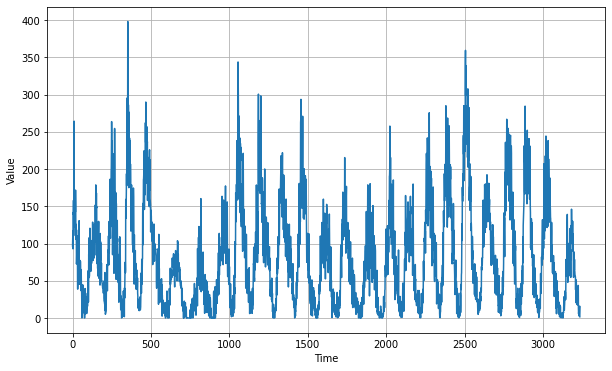

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 100
shuffle_buffer_size = 1000


In [8]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)
# train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# model = tf.keras.models.Sequential([
#   # tf.keras.layers.Conv1D(filters=64, kernel_size=5,
#   #                     strides=1, padding="causal",
#   #                     activation="relu",
#   #                     input_shape=[None, 1]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Dense(1),
# ])

# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(train_set,epochs=100,verbose=0,callbacks=[lr_schedule])

In [9]:
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [10]:
from math import exp
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

def lr_decay(epoch):
  if epoch>600:
    return 1e-6
  else:
    return 5e-6
lrate = tf.keras.callbacks.LearningRateScheduler(lr_decay)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  # tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=600,verbose=2)#,callbacks=[lrate])

Epoch 1/600
30/30 - 15s - loss: 49.7554 - mae: 50.2529
Epoch 2/600
30/30 - 1s - loss: 27.1204 - mae: 27.6152
Epoch 3/600
30/30 - 1s - loss: 21.4611 - mae: 21.9548
Epoch 4/600
30/30 - 1s - loss: 19.3729 - mae: 19.8660
Epoch 5/600
30/30 - 1s - loss: 18.3678 - mae: 18.8602
Epoch 6/600
30/30 - 1s - loss: 17.4841 - mae: 17.9762
Epoch 7/600
30/30 - 1s - loss: 17.1211 - mae: 17.6128
Epoch 8/600
30/30 - 1s - loss: 16.5477 - mae: 17.0392
Epoch 9/600
30/30 - 1s - loss: 16.3661 - mae: 16.8575
Epoch 10/600
30/30 - 1s - loss: 16.1929 - mae: 16.6843
Epoch 11/600
30/30 - 1s - loss: 16.2458 - mae: 16.7373
Epoch 12/600
30/30 - 1s - loss: 15.8454 - mae: 16.3362
Epoch 13/600
30/30 - 1s - loss: 15.6719 - mae: 16.1629
Epoch 14/600
30/30 - 1s - loss: 15.6236 - mae: 16.1144
Epoch 15/600
30/30 - 1s - loss: 15.5338 - mae: 16.0249
Epoch 16/600
30/30 - 1s - loss: 15.3536 - mae: 15.8443
Epoch 17/600
30/30 - 1s - loss: 15.5539 - mae: 16.0450
Epoch 18/600
30/30 - 1s - loss: 15.7071 - mae: 16.1979
Epoch 19/600
30/30

In [11]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)

# a = np.array([[[a],[b],[1]],[[a],[b],[2]],[[a],[b],[3]],[[a],[b],[4]],[[a],[b],[5]]])
# a[:, -1] -> array([[1], [2], [3], [4], [5]])
# a[:, -1, 0] -> array([1, 2, 3, 4, 5])
# :-1 because it function will predict +1 from valid dataset on the last window of series.
# The model is duplicating dense layer as sequence is passed to dense.
# With a[:, -1, 0] we only take the  last value of the dense layer.
# But how does loss function treats this???

rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

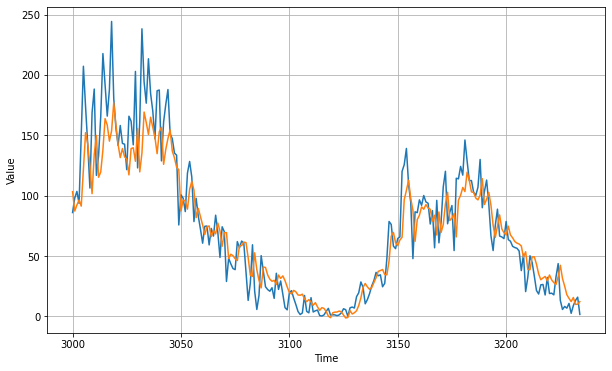

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.023027

<Figure size 432x288 with 0 Axes>

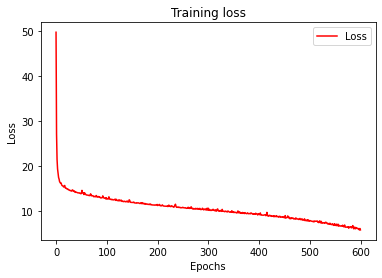

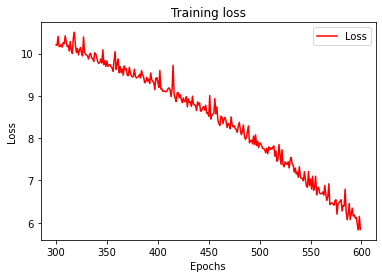

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[300:]
zoomed_epochs = range(300,600)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()